In [1]:
import fastai.vision.all as fv
import torch
import pathlib as Path

In [3]:
!ls "/storage"

'birds(small).zip'   dark_art.jpg   data


In [1]:
#!unzip "storage/birds(small).zip"

In [4]:
files = fv.get_image_files("birds_small")
files #Todas las imagenes del folder


(#11788) [Path('birds_small/train/Acadian_Flycatcher/Acadian_Flycatcher_0003_29094.jpg'),Path('birds_small/train/Acadian_Flycatcher/Acadian_Flycatcher_0004_795623.jpg'),Path('birds_small/train/Acadian_Flycatcher/Acadian_Flycatcher_0006_795595.jpg'),Path('birds_small/train/Acadian_Flycatcher/Acadian_Flycatcher_0007_795600.jpg'),Path('birds_small/train/Acadian_Flycatcher/Acadian_Flycatcher_0008_795599.jpg'),Path('birds_small/train/Acadian_Flycatcher/Acadian_Flycatcher_0009_29155.jpg'),Path('birds_small/train/Acadian_Flycatcher/Acadian_Flycatcher_0010_29199.jpg'),Path('birds_small/train/Acadian_Flycatcher/Acadian_Flycatcher_0014_795607.jpg'),Path('birds_small/train/Acadian_Flycatcher/Acadian_Flycatcher_0016_29217.jpg'),Path('birds_small/train/Acadian_Flycatcher/Acadian_Flycatcher_0017_795598.jpg')...]

## Abriendo los datos en fastai     
Datablock. Es la manera de fast.ai deponer los datos
batch size .- cuántas imágenes le voy a pasar

In [5]:
def load_data(folder, img_size,batch_size):
    tmfs = fv.aug_transforms(flip_vert=True,
                            max_rotate=360,
                            max_lighting=0.25,
                            max_zoom=1.2,
                            max_warp=0.2)
    data = fv.DataBlock(blocks  = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter  = fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms = fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms = tmfs)
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches

In [6]:
data = load_data("birds_small/", img_size=128, batch_size=64)#128 lo podemos mover

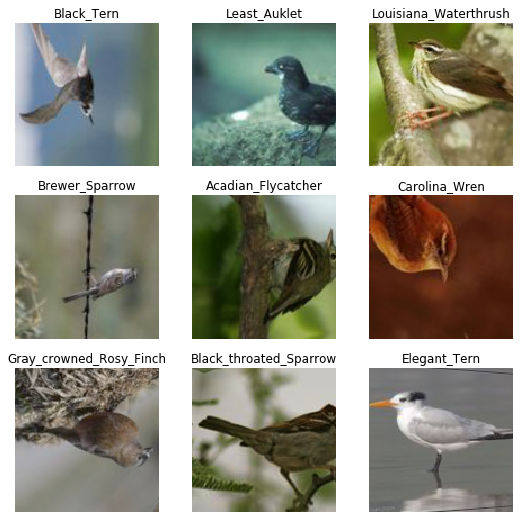

In [7]:
data.show_batch() #Las imagenes que hay en el batch

In [8]:
x,y = data.one_batch()

In [9]:
x.shape
#Batch size, coloresm tamano imagenes


torch.Size([64, 3, 128, 128])

In [10]:
y.shape # Categorias

torch.Size([64])

## Entrenamiento

Crear Learner, arquitectura resnet18 <- modelo

Learner:
- Datos
- Modelo(Red neuronal)
- Funcion de perdida
- Optimizador
cnn_learner <- red convolucional


In [11]:
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy) #la primera vez ecarga la arquitectura Resnec18

In [12]:
learner.summary() #bloques que conforman a la red neuronal

Sequential (Input shape: ['64 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 64 x 64    9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 64 x 64    128        True      
________________________________________________________________
ReLU                 64 x 64 x 64 x 64    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 32 x 32    0          False     
________________________________________________________________
Conv2d               64 x 64 x 32 x 32    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 32 x 32    128        True      
________________________________________________________________
ReLU                 64 x 64 x 32 x 32    0          False     
_________________________________________________

In [12]:
## Entrenamos las ultimas capas

learner.lr_find()#Entrena y carga el modelo inicial. No se queda con el modelo explotado

OSError: [Errno 12] Cannot allocate memory

Me salió ese error de la memoria, así que bajé algunos parámetros

In [13]:
data = load_data("birds_small/", img_size=128, batch_size=32)#bajé el tamaño del batch de 64 a 32

In [14]:
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy) #la primera vez ecarga la arquitectura Resnec18

In [15]:
learner.lr_find()#Entrena y carga el modelo inicial. No se queda con el modelo explotado

OSError: [Errno 12] Cannot allocate memory

Me mandó el msimo error.
Busqué en el video si haía lago que no puse
Volví a bajar el tamaño del batch

In [17]:
data = load_data("birds_small/", img_size=128, batch_size=16)#bajé el tamaño del batch de 64 a 32

In [19]:
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy) #la primera vez ecarga la arquitectura Resnec18

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=1.5848931980144698e-06)

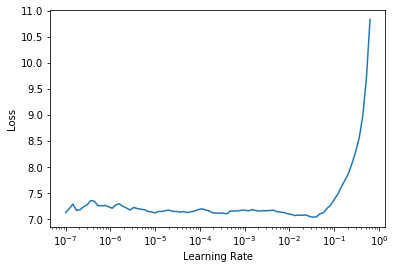

In [20]:
learner.lr_find()#Entrena y carga el modelo inicial. No se queda con el modelo explotado

En la gráfica debemos busacr learning rates donde no la pendiente sea el mínimo porque explota muy rápido. Fijaronos donde hay mucha pendiente

In [21]:
learner.fit_one_cycle(1,lr_max=0.003)#epocas, learning_rate

epoch,train_loss,valid_loss,accuracy,time
0,4.661660,None,None,04:42


/usr/local/lib/python3.6/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


El entrenamiento es algo tardado para ser paperspace y la máquina que me dió. Entonces voy a revisar si tarda porque cada batch es de temaño 16 o si hay algún problema con las imágenes y las carpetas

Descarto el proiblema de las imágenes porque todo está en orden con las carpetas y el contenido. Ahora veré qué es lo que pasa con el tamaño del batch.

Hice pruebas antes deonde le pasé el tamaño de batch de 64 y entrenaba la época en 11s

Además de eso, me mandó un error "Your generator is empty."
    
"
impiyush
    Feb 26
    From the error it seems like there is no data in the path. Have you checked if your ‘path’ is set correctly? Can you share the folder structure for your data?
"
Revisé en los foros de fastai y comentaron eso. Veré qué pasa con mis carpetas. 
    https://forums.fast.ai/t/some-questions-in-lesson-2-userwarning-your-generator-is-empty/64134

En el video que usted hizo, puso los nombres de carpetas como "train" y "valid". Voy a cambiar los nombres de las carpetas

Haré pruebas de nuevo

In [22]:
data = load_data("birds_small/", img_size=128, batch_size=16)#prueba con los 16 de hace rato

In [23]:
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)

SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=1.0964781722577754e-06)

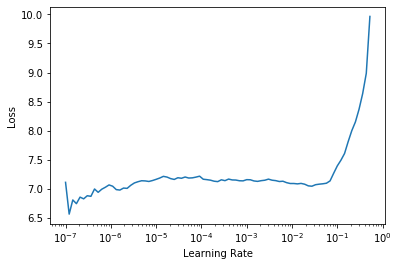

In [24]:
learner.lr_find() ##Encontrar el valor de lr

Sigue tardando demasiado, pero no sé si sea porque los batch son de tamaño 16

In [25]:
learner.fit_one_cycle(1,lr_max=0.003)#epocas, learning_rate

epoch,train_loss,valid_loss,accuracy,time
0,4.616084,3.485599,0.194512,06:43


También revisé las especificaciones de la máquina que me dan en paperspace

Machine Specs
Processor: Intel Xeon
CPU Count: 2 vCPUs
Clock Speed: 2.10 GHz
Intel AVX: yes
Intel AVX2: yes
Host Memory: 2 GB

Parece que tarda porque no me está dando GPU

Acabando de entrenar esta época voy a apagar la máquina y volverla a encender revisando que me den GPU

In [26]:
learner.save('stage1_birds') # Para guardar el modelo.

Path('models/stage1_birds.pth')

Después de haber reiniciado la máquina, estan son las caracteristicas:
Processor: Intel Xeon
CPU Count: 8 vCPUs
Clock Speed: 2.60 GHz
Intel AVX: yes
Intel AVX2: yes
Host Memory: 30 GB
GPU x 1
Type:NVIDIA QUADRO M4000
Memory: 8 GB
CUDA: unknown

Entonces volví a correr los imports y la funcion load_data

In [13]:
data = load_data("birds_small/", img_size=128, batch_size=64)#Como ya tengo GPU ahora le vuelvo a pasar el batch de tamaño 64

In [14]:
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.015848932787775993)

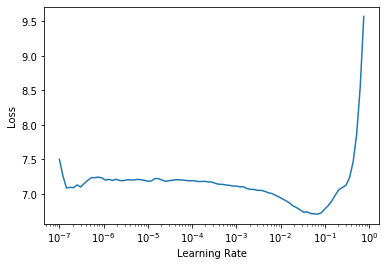

In [15]:
learner.lr_find() ##Encontrar el valor recomendado de lr

No cargué el modelo que había guardado porque ahora le voy a pasar un batch más grande

In [16]:
#pongo al modelo que entrene por tres épocas
learner.fit_one_cycle(3,lr_max=0.003)#epocas, learning_rate

epoch,train_loss,valid_loss,accuracy,time
0,5.555297,3.658319,0.189334,00:16
1,4.027792,2.713100,0.312565,00:16
2,3.234758,2.564991,0.348119,00:16


Aquí se nota una diferencia abismal en el tiempo de entrenamiento.

Otra de las diferncias que no documeté es que si no cambiaba el nombre de las carpeta "test" a "valid" la accuracy da None

Bueno, está bien, lo haré de nuevo para probarlo...

In [17]:
data = load_data("birds_small/", img_size=128, batch_size=64)#Como ya tengo GPU ahora le vuelvo a pasar el batch de tamaño 64

In [18]:
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.019054606556892395)

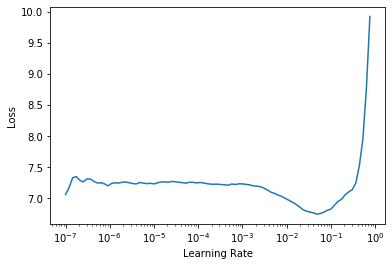

In [19]:
learner.lr_find() ##Encontrar el valor recomendado de lr

In [20]:
learner.fit_one_cycle(3,lr_max=0.004)#epocas, learning_rate

epoch,train_loss,valid_loss,accuracy,time
0,5.441011,None,None,00:11
1,3.920157,None,None,00:11
2,3.127955,None,None,00:11


/usr/local/lib/python3.6/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


En el entrenamiento de arriba da None en la accuracy. Para evitar eso tuve que cambiar el nombre de la carpeta "test" a "valid".
Le volveré a cambiar el nombre

In [21]:
data = load_data("birds_small/", img_size=128, batch_size=64)#Como ya tengo GPU ahora le vuelvo a pasar el batch de tamaño 64

In [22]:
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.019054606556892395)

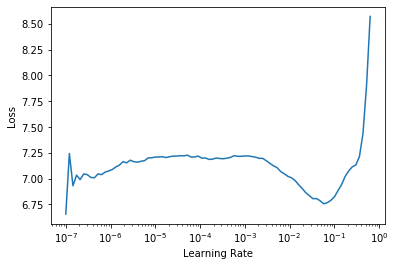

In [23]:
learner.lr_find() ##Encontrar el valor recomendado de lr

Ahora voy a entrenar unas épocas para tratar de llegar a un buen accuracy

In [24]:
learner.fit_one_cycle(7,lr_max=0.005)#epocas, learning_rate

epoch,train_loss,valid_loss,accuracy,time
0,5.963228,3.941813,0.159993,00:16
1,4.321174,3.018240,0.270107,00:16
2,3.592386,2.725130,0.323611,00:17
3,3.044558,2.449861,0.371074,00:17
4,2.639804,2.257133,0.415775,00:16
5,2.296975,2.113627,0.448740,00:16
6,2.156043,2.089600,0.454090,00:16


Es monstruosa la velocidad de la máquina de paperspace con GPU

Con estos resultados podemo ver que la accuracy es mala. Debo cambiar algunos parámetros.

Voy a guardar el modelo en stage 2
Voy a mostrar algunos resultados de cómo hace la (mala) clasificación. 

In [25]:
learner.save('stage2')

Path('models/stage2.pth')

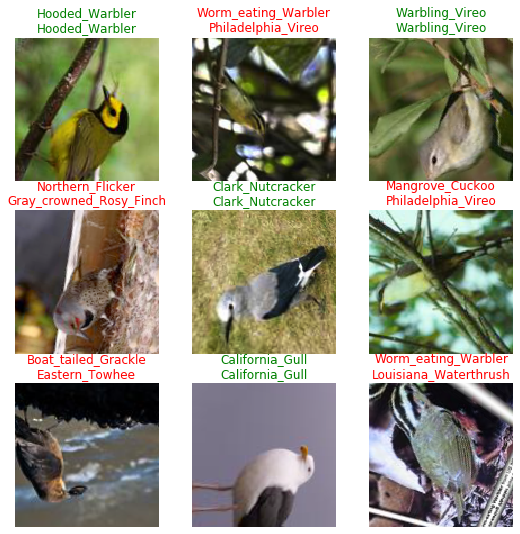

In [27]:
learner.show_results(ds_idx=3,dl=data.train,shuffle=True)

En el ejemplo se ve, justamente que de las 9 imágenes sólo clasificó bien 4.

Para ver la accuracy

In [28]:
learner.validate()

(#2) [2.089600086212158,0.4540904462337494]

la accurracy es del 45%

Ahora voy a entrenar con diferentes parámetros

## Primero le voy a pasar batches más pequeños con los mismos parámetros

In [29]:
def load_data(folder, img_size,batch_size):
    tmfs = fv.aug_transforms(flip_vert=True,
                            max_rotate=360,
                            max_lighting=0.25,
                            max_zoom=1.2,
                            max_warp=0.2)
    data = fv.DataBlock(blocks  = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter  = fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms = fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms = tmfs)
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches

In [30]:
data = load_data("birds_small/", img_size=128, batch_size=32)

In [31]:
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=6.309573450380412e-07)

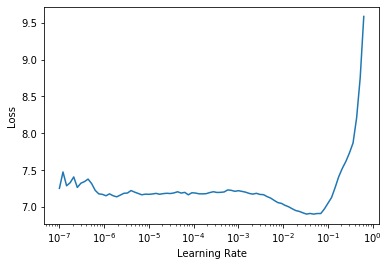

In [32]:
learner.lr_find()

Y lo voy a entrenar para 3 épocas

In [33]:
learner.fit_one_cycle(3,lr_max=0.004)#epocas, learning_rate

epoch,train_loss,valid_loss,accuracy,time
0,5.038569,3.719308,0.184156,00:20
1,3.738718,2.732616,0.309458,00:20
2,3.053762,2.467501,0.371764,00:20


Este entrenamiento tuvo mejores resultados que lso primeros 3 con un batch de 64 imagenes

Ahora voy a hacerlo con el mismo tamaño del batch, pero con las imágenes más grandes

In [35]:
data = load_data("birds_small/", img_size=256, batch_size=64)

In [36]:
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.02754228748381138)

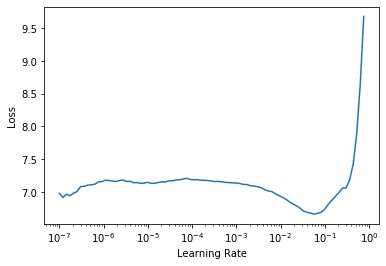

In [37]:
learner.lr_find()

In [38]:
learner.fit_one_cycle(3,lr_max=0.005)#epocas, learning_rate

epoch,train_loss,valid_loss,accuracy,time
0,5.072071,3.245113,0.254229,00:48
1,3.532180,2.225394,0.420780,00:47
2,2.673737,1.961440,0.486020,00:47


Con las tres primeras iteraciones se ve que sí aumenta el accuracy con duplicar el tamaño de las imagenes

Ahora las voy a volver a duplicar, con el mismo tamaño del batch a ver qué tal se comporta el accuracy

In [40]:
data = load_data("birds_small/", img_size=512, batch_size=64)

In [41]:
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)

In [42]:
learner.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 7.94 GiB total capacity; 7.32 GiB already allocated; 21.00 MiB free; 7.38 GiB reserved in total by PyTorch)
Exception raised from malloc at /pytorch/c10/cuda/CUDACachingAllocator.cpp:272 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x42 (0x7fd6b4d8d1e2 in /usr/local/lib/python3.6/dist-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1e64b (0x7fd6b4fe364b in /usr/local/lib/python3.6/dist-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x1f464 (0x7fd6b4fe4464 in /usr/local/lib/python3.6/dist-packages/torch/lib/libc10_cuda.so)
frame #3: <unknown function> + 0x1faa1 (0x7fd6b4fe4aa1 in /usr/local/lib/python3.6/dist-packages/torch/lib/libc10_cuda.so)
frame #4: at::native::empty_cuda(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x11e (0x7fd65bd3890e in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xf33949 (0x7fd65a172949 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0xf4d777 (0x7fd65a18c777 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cuda.so)
frame #7: <unknown function> + 0x10e9c7d (0x7fd694f28c7d in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0x10e9f97 (0x7fd694f28f97 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #9: at::empty(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0xfa (0x7fd695033a1a in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #10: at::TensorIterator::fast_set_up(at::TensorIteratorConfig const&) + 0x56a (0x7fd694cc0f8a in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #11: at::TensorIterator::build(at::TensorIteratorConfig&) + 0x76 (0x7fd694cc4ff6 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #12: at::TensorIterator::TensorIterator(at::TensorIteratorConfig&) + 0xdd (0x7fd694cc565d in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #13: at::TensorIterator::binary_op(at::Tensor&, at::Tensor const&, at::Tensor const&, bool) + 0x14a (0x7fd694cc580a in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #14: at::native::add(at::Tensor const&, at::Tensor const&, c10::Scalar) + 0x47 (0x7fd694a02717 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #15: <unknown function> + 0xf1dec0 (0x7fd65a15cec0 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cuda.so)
frame #16: <unknown function> + 0xa9b254 (0x7fd6948da254 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #17: at::add(at::Tensor const&, at::Tensor const&, c10::Scalar) + 0x183 (0x7fd69500a583 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #18: <unknown function> + 0x2e8a081 (0x7fd696cc9081 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #19: <unknown function> + 0xa9b254 (0x7fd6948da254 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #20: at::Tensor::add(at::Tensor const&, c10::Scalar) const + 0x183 (0x7fd69517df73 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #21: <unknown function> + 0x3382330 (0x7fd6971c1330 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #22: <unknown function> + 0x3383083 (0x7fd6971c2083 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #23: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&, std::shared_ptr<torch::autograd::ReadyQueue> const&) + 0xb80 (0x7fd6971afb80 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #24: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&) + 0x451 (0x7fd6971b0fa1 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #25: torch::autograd::Engine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x89 (0x7fd6971a9119 in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_cpu.so)
frame #26: torch::autograd::python::PythonEngine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x4a (0x7fd6b5b3f4ba in /usr/local/lib/python3.6/dist-packages/torch/lib/libtorch_python.so)
frame #27: <unknown function> + 0xbd66f (0x7fd6c9a7666f in /usr/lib/x86_64-linux-gnu/libstdc++.so.6)
frame #28: <unknown function> + 0x76db (0x7fd6cf2c76db in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #29: clone + 0x3f (0x7fd6cf60088f in /lib/x86_64-linux-gnu/libc.so.6)


Y con el tamaño de 512 me quedé sin memoria. 
Como sé que es una buena práctica ponerlos en base 2, dejaré el tamaño de la iimágen en 256

Ahora voy a mandar un batch más grande

In [43]:
data = load_data("birds_small/", img_size=256, batch_size=128)
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)
learner.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 7.94 GiB total capacity; 7.34 GiB already allocated; 19.00 MiB free; 7.38 GiB reserved in total by PyTorch)

Y también se quedó sin memoria.

Entonces, el batch será de tamaño 64 y el tamaño de la imágen de 256 (quer ya hice la prueba con estos valores y la tervera época me dio accuracy de 0.4860)

In [44]:
data = load_data("birds_small/", img_size=256, batch_size=64)
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)
learner.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.94 GiB total capacity; 7.38 GiB already allocated; 13.00 MiB free; 7.39 GiB reserved in total by PyTorch)

Como me dio un error, la verdad no sé porqué fue, voy a hacer los comandos uno en cada línea diferente

In [45]:
data = load_data("birds_small/", img_size=256, batch_size=128)

In [46]:
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)

In [47]:
learner.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.94 GiB total capacity; 7.39 GiB already allocated; 9.00 MiB free; 7.39 GiB reserved in total by PyTorch)

Había olvidado cambier el tamaño del batch a 64

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.015848932787775993)

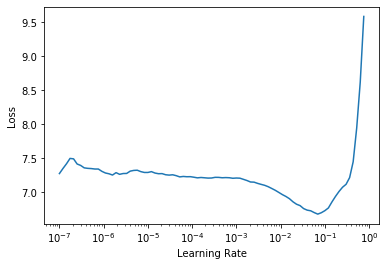

In [48]:
data = load_data("birds_small/", img_size=256, batch_size=64)
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)
learner.lr_find()

In [49]:
learner.fit_one_cycle(3,lr_max=0.005)#epocas, learning_rate

epoch,train_loss,valid_loss,accuracy,time
0,5.148886,3.166614,0.254401,00:47
1,3.564589,2.176083,0.423714,00:47
2,2.709934,1.955625,0.487746,00:47


Debe superar en la tercera iteracion a los 0.486 de accuracy

Y apenas lo mejoró...

entonces modificaré el learning rate

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=9.12010818865383e-07)

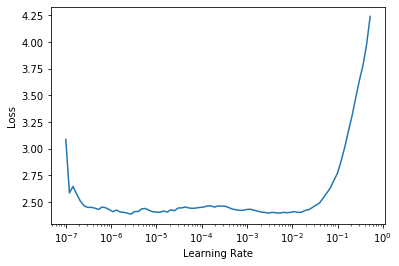

In [50]:
learner.lr_find()

In [51]:
learner.fit_one_cycle(3,lr_max=2.75e-7)

epoch,train_loss,valid_loss,accuracy,time
0,2.386902,1.946288,0.488609,00:47
1,2.396222,1.953426,0.488954,00:47
2,2.411570,1.951619,0.486883,00:47


Aquí es interesante que el learning rate que no recomendó es muy muy pequeño y por eso da la impresión de quedar estancado en 0.48

Voy a probar ahora con un learning rate diferente

SuggestedLRs(lr_min=3.981071586167673e-07, lr_steep=1.0964781722577754e-06)

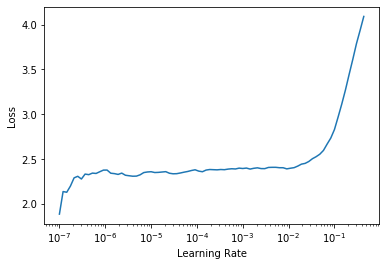

In [52]:
learner.lr_find()

### Bueno, dado que el lr no cambia en el órden de magnitud, ahora voy a modificar los parámetros de la funcion load_data

In [53]:
fv.doc(fv.aug_transforms)

aug_transforms [source] aug_transforms ( mult = 1.0 , do_flip = True , flip_vert = False , max_rotate = 10.0 , min_zoom = 1.0 , max_zoom = 1.1 , max_lighting = 0.2 , max_warp = 0.2 , p_affine = 0.75 , p_lighting = 0.75 , xtra_tfms = None , size = None , mode = 'bilinear' , pad_mode = 'reflection' , align_corners = True , batch = False , min_scale = 1.0 ) 
 
 Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms. 
 Show in docs

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.019054606556892395)

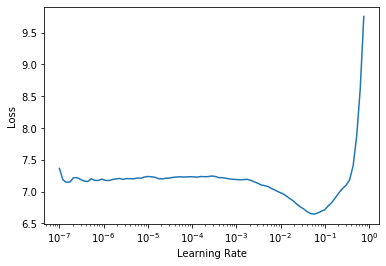

In [56]:
def load_data(folder, img_size,batch_size):
    tmfs = fv.aug_transforms(flip_vert=True, #Las aves pueden aparecer de cabeza
                            do_flip = True, #Rota horizontalmente
                            max_rotate=10, #Las aves pueden aparecer volando o parados o de cabeza
                            max_lighting=0.2,
                            min_zoom=1,
                            max_zoom=1.2,
                            max_warp=0.2,
                            p_affine = 0.5)#Random rotation of max_rotate degrees                             )
    data = fv.DataBlock(blocks  = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter  = fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms = fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms = tmfs)
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches
    
data = load_data("birds_small/", img_size=256, batch_size=64) #Ya quedamos estos valores
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)
learner.lr_find()

In [57]:
learner.fit_one_cycle(3,lr_max=0.005)

epoch,train_loss,valid_loss,accuracy,time
0,4.991840,2.966475,0.294443,00:47
1,3.291910,1.944764,0.489644,00:47
2,2.400703,1.743590,0.540387,00:47


Se ve una mejora en el accuracy, poniendo una nueva meta 0.54

Seguimos haciendo modificaciones en la funcion

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.02754228748381138)

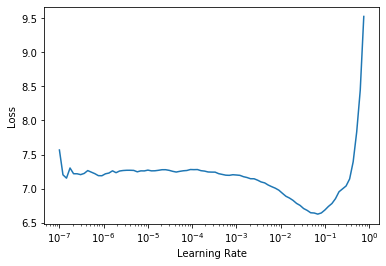

In [58]:
def load_data(folder, img_size,batch_size):
    tmfs = fv.aug_transforms(flip_vert=True, #Las aves pueden aparecer de cabeza
                            do_flip = True, #Rota horizontalmente
                            max_rotate=5, #Las aves pueden aparecer volando o parados o de cabeza
                            max_lighting=0.2,
                            min_zoom=1,
                            max_zoom=1.5,
                            max_warp=0.2,
                            p_affine = 0.5)#Random rotation of max_rotate degrees                             )
    data = fv.DataBlock(blocks  = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter  = fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms = fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms = tmfs)
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches
    
data = load_data("birds_small/", img_size=256, batch_size=64) #Ya quedamos estos valores
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)
learner.lr_find()

In [59]:
learner.fit_one_cycle(3,lr_max=0.006)

epoch,train_loss,valid_loss,accuracy,time
0,4.943419,2.945599,0.295478,00:47
1,3.362079,2.001495,0.472385,00:47
2,2.484691,1.723300,0.543838,00:47


Ahora que con estos parámetros de la función  load_data logré subir hasta 0.5438 (un nuevo máximo). voy a hacer iteraciones hasta converger

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=1.4454397387453355e-05)

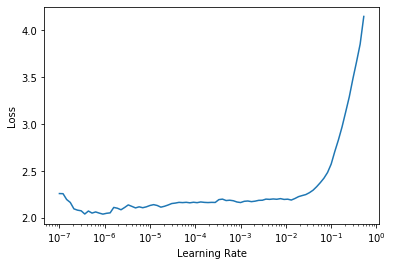

In [60]:
learner.lr_find()

Aquí no entiendo por qué el lr baja tantos ordenes de magnitud

In [61]:
learner.fit_one_cycle(3,lr_max=9e-8)

epoch,train_loss,valid_loss,accuracy,time
0,2.165813,1.727569,0.543148,00:47
1,2.177263,1.723771,0.542803,00:47
2,2.155061,1.723843,0.541767,00:47


In [ ]:
Se ve que el accuracy se estanca

Ahora voy a hacer las 15 iteraciones, pero cargando de nuevo los datos desde la funcion load_data y con el lr sugerido(que no va a ser tan pequeño como el del grafico anterior)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.02290867641568184)

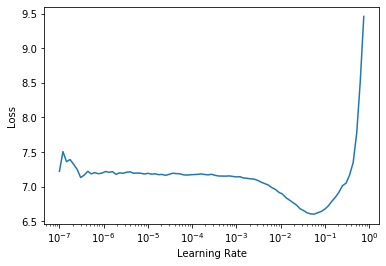

In [62]:
def load_data(folder, img_size,batch_size):
    tmfs = fv.aug_transforms(flip_vert=True, #Las aves pueden aparecer de cabeza
                            do_flip = True, #Rota horizontalmente
                            max_rotate=5, #Las aves pueden aparecer volando o parados o de cabeza
                            max_lighting=0.2,
                            min_zoom=1,
                            max_zoom=1.5,
                            max_warp=0.2,
                            p_affine = 0.5)#Random rotation of max_rotate degrees                             )
    data = fv.DataBlock(blocks  = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter  = fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms = fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms = tmfs)
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches
    
data = load_data("birds_small/", img_size=256, batch_size=64) #Ya quedamos estos valores
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)
learner.lr_find()

In [63]:
learner.fit_one_cycle(15,lr_max=0.005)

epoch,train_loss,valid_loss,accuracy,time
0,6.297569,4.298774,0.110114,00:47
1,4.407327,2.559543,0.363479,00:47
2,3.327119,2.157369,0.445288,00:47
3,2.852404,2.018006,0.476700,00:47
4,2.556546,1.966267,0.488609,00:47
5,2.316825,1.769877,0.530031,00:47
6,2.125267,1.676447,0.549189,00:47
7,1.918113,1.616421,0.562133,00:47
8,1.758297,1.531615,0.590784,00:48
9,1.583051,1.417294,0.610632,00:48


En lo que se entrena quiero escribir que si el lr es muy chiquito se puede quedar estancado en un mínimo local, por eso en el ejemplo de poquito arriba, se ve como que converge o se estanca, pues es muy probable que haya alcanzado un mínimo local y por tener un lr muy chiquito ya no salío de allí

En la iteracion 15 se ve que es menor que la 14, y da indicios de que converge. Haré mas iteraciones para ver qué es lo que hace

In [64]:
learner.fit_one_cycle(25,lr_max=0.005)

KeyboardInterrupt: 

Interrumpí porque en lugar de subir accuracy, bajaba

Voy a seguir haciendo pruebas en los parámetros de load_data

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.02290867641568184)

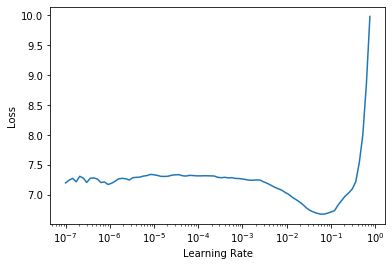

In [3]:
def load_data(folder, img_size,batch_size):
    tmfs = fv.aug_transforms(flip_vert=True, #Las aves pueden aparecer de cabeza
                            do_flip = True, #Rota horizontalmente
                            max_rotate=10, #Las aves pueden aparecer volando o parados o de cabeza
                            max_lighting=0.2,
                            min_zoom=1,
                            max_zoom=1.2,
                            max_warp=0.2,
                            p_affine = 0.5)#Random rotation of max_rotate degrees                             )
    data = fv.DataBlock(blocks  = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter  = fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms = fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms = tmfs)
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches
    
data = load_data("birds_small/", img_size=256, batch_size=64) #Ya quedamos estos valores
learner = fv.cnn_learner(data, fv.resnet18, metrics = fv.accuracy)
learner.lr_find()

In [4]:
learner.fit_one_cycle(25,lr_max=0.005)

epoch,train_loss,valid_loss,accuracy,time
0,6.567345,4.838345,0.054884,00:49
1,5.054376,2.985934,0.292544,00:49
2,3.607690,2.173463,0.435968,00:48
3,2.885044,1.987296,0.477045,00:49
4,2.588866,2.111086,0.464101,00:48
5,2.443822,2.097245,0.466517,00:49
6,2.282385,1.937415,0.506559,00:49
7,2.167826,1.821667,0.525198,00:49
8,2.030105,1.715911,0.543493,00:48
9,1.889079,1.744064,0.543148,00:49


La pérdida está bajando

Llegué a un punto donde convergen mis accuracy.
Las accuracy han sido las mayores que he tenido.

Si quiero mejorar mis accuracy debería in tentar cin el dataset completo y con un aarquitectura diferente a resnet18

### guardar los resultados

In [5]:
learner.save("max_accuracy")

Path('models/max_accuracy.pth')

### Entrenar todas las capas

In [7]:
learner.unfreeze()

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=2.2908675418875646e-06)

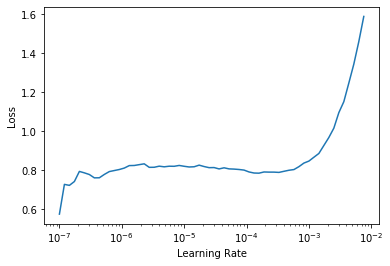

In [8]:
learner.lr_find()

In [10]:
learner.fit_one_cycle(20,lr_max=slice(1.5e-5,5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.815472,1.332577,0.649465,01:01
1,0.881305,1.433463,0.632724,01:01
2,1.081591,1.656998,0.581809,01:01
3,1.363325,1.759768,0.552641,01:01
4,1.479113,1.858582,0.531930,01:01
5,1.406293,1.672126,0.573524,01:01
6,1.247071,1.648829,0.583707,01:01
7,1.148851,1.636323,0.588540,01:01
8,1.063191,1.568804,0.598205,01:01
9,0.948077,1.499796,0.628581,01:01


In [11]:
learner.save("max_accuracy_unfreeze")

Path('models/max_accuracy_unfreeze.pth')

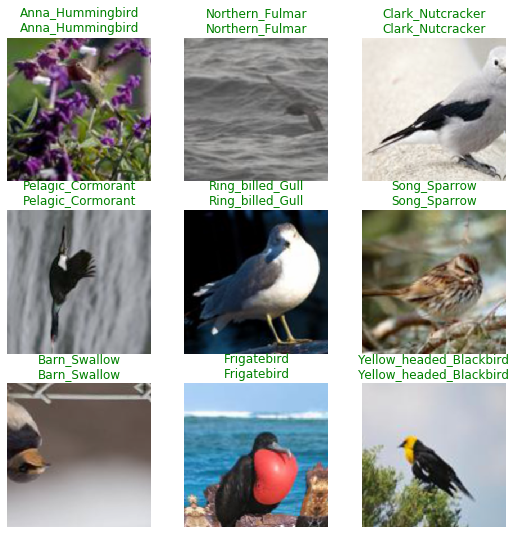

In [12]:
learner.show_results(ds_idx=3, dl=data.train,shuffle=True)

Yuuujuuuu, después de hacer varias y emocionante spruebas pude hacer que el accuracy fuera bueno (al menos no tan malo)

## Interpretando los resultados

In [13]:
interp = fv.ClassificationInterpretation.from_learner(learner)

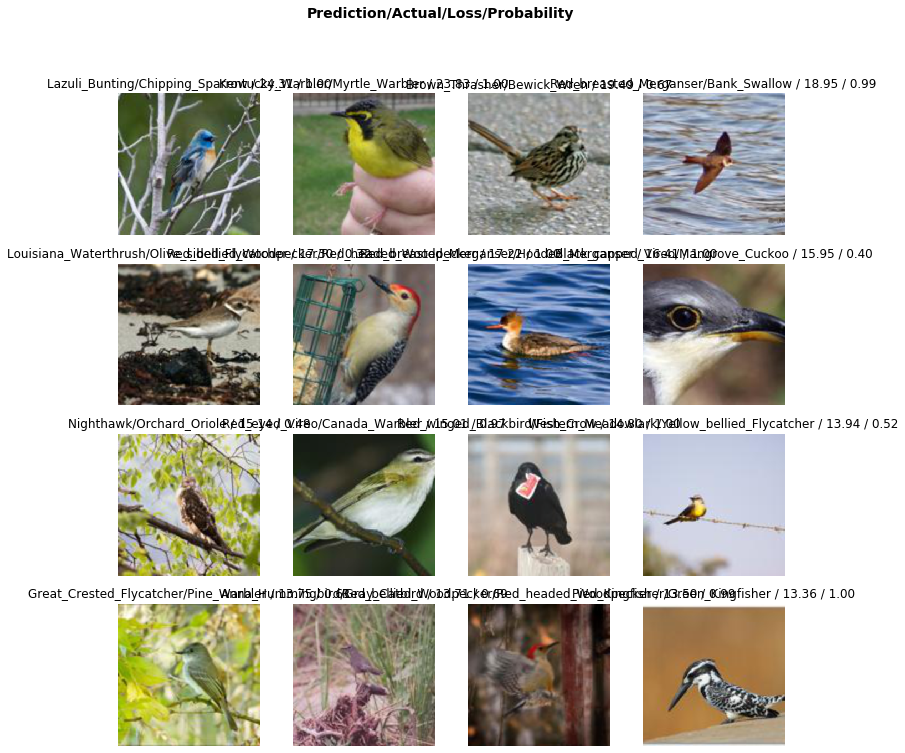

In [14]:
interp.plot_top_losses(16)

En estas categorías tuvo más problema mi modelo para hacer la clasificación

In [ ]:
Y bueno, cómo aún tengo tiempo voy a seguir entrenando mi red muajajajaja

In [15]:
learner.load("max_accuracy_unfreeze")

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.981071586167673e-06)

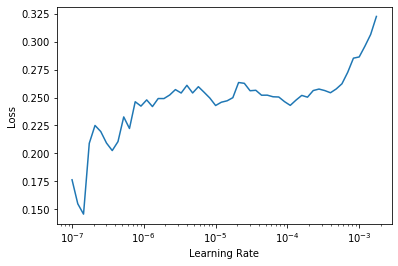

In [16]:
learner.lr_find()

In [17]:
learner.fit_one_cycle(20,lr_max=6.3e-8)

epoch,train_loss,valid_loss,accuracy,time
0,0.260983,1.309727,0.682430,01:02
1,0.272937,1.310468,0.679841,01:02
2,0.248973,1.314157,0.682085,01:02
3,0.251892,1.316101,0.681567,01:02
4,0.256842,1.313120,0.682775,01:03
5,0.265064,1.308797,0.682258,01:02
6,0.262866,1.310833,0.682258,01:02
7,0.270271,1.314304,0.681912,01:02
8,0.245517,1.312889,0.682430,01:03
9,0.261943,1.308984,0.683638,01:02


Bueno, parece que encontró un míninmo local y se quedó estancado en 68.xxx

Pero eso no me desanima de seguir haciendo pruebas...


SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=1.0964781722577754e-06)

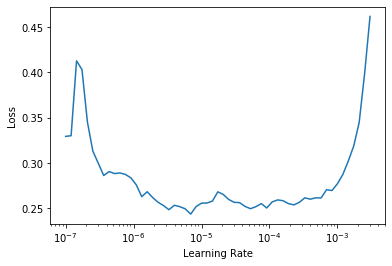

In [18]:
learner.lr_find()

In [19]:
learner.fit_one_cycle(15,lr_max=6.9e-7)

epoch,train_loss,valid_loss,accuracy,time
0,0.255361,1.310500,0.680877,01:02
1,0.249014,1.315090,0.681912,01:02
2,0.254166,1.313735,0.680186,01:02
3,0.266963,1.313439,0.681395,01:02
4,0.246080,1.308427,0.683293,01:02
5,0.256719,1.309029,0.682085,01:02
6,0.269481,1.307845,0.682603,01:03
7,0.253640,1.307956,0.680359,01:02
8,0.251699,1.311386,0.681567,01:02
9,0.244529,1.306838,0.682430,01:02


Probando con el lr que me recomienda parece que se queda estancada el accuracy
La siguiente vez voy a poner otro lr

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=6.918309736647643e-06)

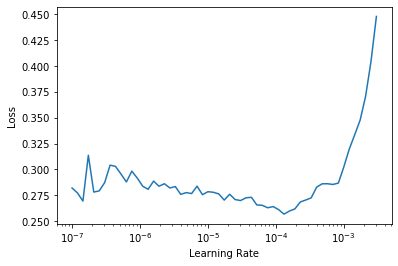

In [20]:
learner.lr_find()

In [21]:
learner.fit_one_cycle(20,lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.268887,1.306961,0.683120,01:03
1,0.255857,1.307229,0.684329,01:02
2,0.230964,1.303101,0.685709,01:03
3,0.265856,1.305900,0.683638,01:02
4,0.257175,1.302609,0.686572,01:02
5,0.240097,1.299632,0.682948,01:02
6,0.235350,1.296482,0.685537,01:02
7,0.241869,1.297467,0.684501,01:02
8,0.232302,1.300000,0.686745,01:02
9,0.218466,1.291933,0.685019,01:02


Bueno, se me acabo el tiempo, pero seguiré intentando